In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import requests
from io import BytesIO
from PIL import Image
from cairosvg import svg2png

In [2]:
#이미지 가져오기
img_bgr = cv2.imread('./images/image.jpg')
# img_bgr = cv2.imread('./images/image.jpg', 0) #gray scale(흑백)로 읽기
img_bgra = cv2.cvtColor(img_bgr, cv2.COLOR_RGB2RGBA) #알파채널 추가
img_bgr = cv2.resize(img_bgra, (640, 360))
img_show = img_bgr.copy() # 출력용 이미지 복사

In [3]:
img_show.shape

(360, 640, 4)

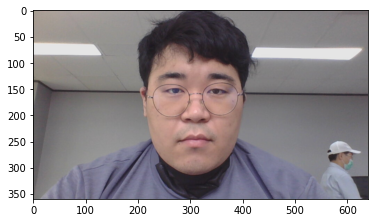

In [4]:
#이미지 확인하기
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGBA)
plt.imshow(img_rgb)
plt.show()

In [5]:
img_show.shape

(360, 640, 4)

In [6]:
import dlib
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언
print("🌫🛸")

🌫🛸


In [7]:
#boundingbox 추출하기
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)
print("🌫🛸")

🌫🛸


rectangles[[(221, 98) (407, 284)]]


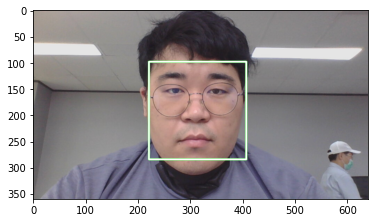

In [8]:
#출력하기
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGBA)
plt.imshow(img_show_rgb)
plt.show()

In [9]:
import os
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
print("🌫🛸")

🌫🛸


In [10]:
#landmark 함수 설정
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


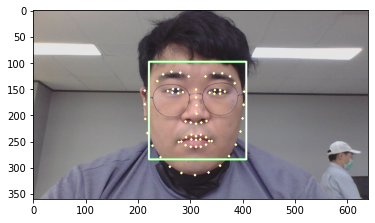

In [11]:
#landmark 표시하기
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGBA)
plt.imshow(img_show_rgb)
plt.show()

In [12]:
img_show_rgb.shape

(360, 640, 4)

In [13]:
#시작점 좌표 확인
x1 = (landmark[2][0] +  landmark[36][0] +  landmark[48][0] +  landmark[30][0])/4
y1 = (landmark[2][1] +  landmark[36][1] +  landmark[48][1] +  landmark[30][1])/4
x2 = (landmark[14][0] +  landmark[45][0] +  landmark[54][0] +  landmark[30][0])/4
y2 = (landmark[14][1] +  landmark[45][1] +  landmark[54][1] +  landmark[30][1])/4
print("({0}, {1})".format(x1, y1)) #시작점 좌표
print("({0}, {1})".format(x2, y2)) #반대편 대칭되는 점의 x좌표

(265.25, 202.25)
(354.75, 201.75)


In [14]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = landmark[30][1]
    w = int((landmark[30][0] - x1) *2) # 스티커의 너비는 이미지 시작점 ~ 얼굴 중심까지의 거리 X 2
#     w = int(x2 - x1)
    h = int(dlib_rect.width() / 4)
#     h = int((y1 - landmark[30][1]) * 2)
    print ('(x,y) : (%d,%d)'%(x,y)) #스티커 위치
    print ('(w,h) : (%d,%d)'%(w,h)) #스티커 크기

(312, 197)
(x,y) : (312,197)
(w,h) : (93,46)


In [15]:
#스티커 불러오기

svg_url = 'https://image.flaticon.com/icons/svg/24/24674.svg'

svg_data = requests.get(svg_url).content

png = svg2png(bytestring=svg_data)

pil_img = Image.open(BytesIO(png)).convert('RGBA')
cv_img = cv2.cvtColor(np.array(pil_img), cv2.COLOR_BGRA2RGBA)
img_sticker = cv2.resize(cv_img, (w,h))
print (img_sticker.shape)

(46, 93, 4)


In [16]:
# #스티커 불러오기
# import os
# sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat.png'
# img_sticker = cv2.imread(sticker_path)
# img_sticker = cv2.resize(img_sticker, (w,h))
# print (img_sticker.shape)

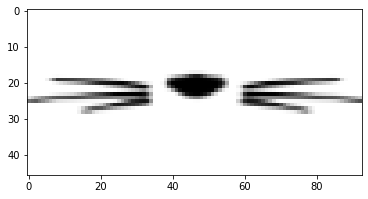

In [17]:
plt.imshow(img_sticker)
plt.show()

In [18]:
# refined_x = x - w // 2  # left
# refined_y = y - h       # top
refined_x = int(x1)
refined_y = int(y1)
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (265,202)


In [19]:
#좌표가 정상으로 나왔으므로 생략
# img_sticker = img_sticker[-refined_y:]
# print (img_sticker.shape)

In [20]:
#원본 이미지에 스티커 적용
sticker_area = img_show[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x + img_sticker.shape[1]]
img_show[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

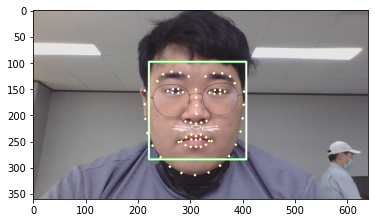

In [21]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGRA2RGBA))
plt.show()

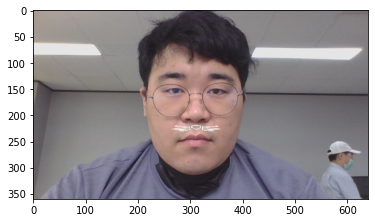

In [22]:
#bounding box와 landmark제거
sticker_area = img_bgr[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x + img_sticker.shape[1]]
img_bgr[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x + img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGBA))
plt.show()

In [23]:
img_bgr3 = cv2.imread('./images/image1.png')
# img_bgr = cv2.imread('./images/image.jpg', 0) #gray scale(흑백)로 읽기
img_bgra3 = cv2.cvtColor(img_bgr3, cv2.COLOR_RGB2RGBA) #알파채널 추가
img_bgr3 = cv2.resize(img_bgra3, (640, 360))
img_show3 = img_bgr3.copy() # 출력용 이미지 복사
img_rgb3 = cv2.cvtColor(img_bgr3, cv2.COLOR_BGR2RGB)
dlib_rects3 = detector_hog(img_rgb3, 1)

rectangles[[(275, 74) (319, 118)], [(89, 61) (141, 113)], [(511, 295) (554, 338)], [(504, 182) (556, 234)], [(287, 267) (349, 329)]]


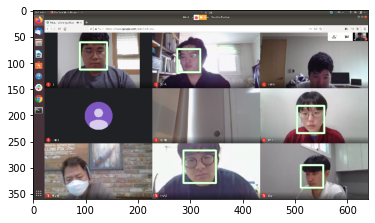

In [24]:
print(dlib_rects3)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects3:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show3, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb3 =  cv2.cvtColor(img_show3, cv2.COLOR_BGR2RGBA)
plt.imshow(img_show_rgb3)
plt.show()

In [25]:
img_bgr3 = cv2.imread('./images/image4.jpg')
# img_bgr = cv2.imread('./images/image.jpg', 0) #gray scale(흑백)로 읽기
img_bgra3 = cv2.cvtColor(img_bgr3, cv2.COLOR_RGB2RGBA) #알파채널 추가
img_bgr3 = cv2.resize(img_bgra3, (640, 360))
img_show3 = img_bgr3.copy() # 출력용 이미지 복사
img_rgb3 = cv2.cvtColor(img_bgr3, cv2.COLOR_BGR2RGB)
dlib_rects3 = detector_hog(img_rgb3, 1)

rectangles[[(285, 180) (328, 223)]]


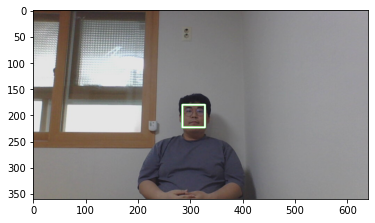

In [26]:
print(dlib_rects3)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects3:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show3, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb3 =  cv2.cvtColor(img_show3, cv2.COLOR_BGR2RGBA)
plt.imshow(img_show_rgb3)
plt.show()

In [27]:
img_bgr3 = cv2.imread('./images/image5.jpg')
# img_bgr = cv2.imread('./images/image.jpg', 0) #gray scale(흑백)로 읽기
img_bgra3 = cv2.cvtColor(img_bgr3, cv2.COLOR_RGB2RGBA) #알파채널 추가
img_bgr3 = cv2.resize(img_bgra3, (360, 640))
img_show3 = img_bgr3.copy() # 출력용 이미지 복사
img_rgb3 = cv2.cvtColor(img_bgr3, cv2.COLOR_BGR2RGB)
dlib_rects3 = detector_hog(img_rgb3, 1)

rectangles[]


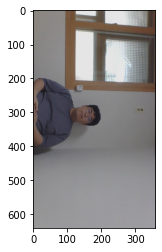

In [28]:
print(dlib_rects3)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects3:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show3, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb3 =  cv2.cvtColor(img_show3, cv2.COLOR_BGR2RGBA)
plt.imshow(img_show_rgb3)
plt.show()

해상도만 충분하다면 이미지가 작거나(멀거나) 여러 사람을 동시에 인식하는 기능도 가능하다. 하지만 얼굴을 90도로 돌리거나 얼굴 윤곽의 일부가 잘리거나 눈, 코, 입 중 하나라도 인식하지 못하면 얼굴로 인식하지 못한다.

In [29]:
img_bgr2 = cv2.imread('./images/image3.jpg')
# img_bgr = cv2.imread('./images/image.jpg', 0) #gray scale(흑백)로 읽기
img_bgra2 = cv2.cvtColor(img_bgr2, cv2.COLOR_RGB2RGBA) #알파채널 추가
img_bgr2 = cv2.resize(img_bgra2, (640, 360))
img_show2 = img_bgr2.copy() # 출력용 이미지 복사

In [30]:
img_rgb2 = cv2.cvtColor(img_bgr2, cv2.COLOR_BGR2RGB)
dlib_rects2 = detector_hog(img_rgb2, 1)   #- (image, num of img pyramid)
print("🌫🛸")

🌫🛸


rectangles[[(311, 96) (440, 225)]]


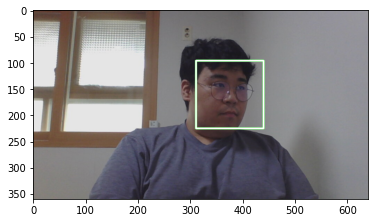

In [31]:
#출력하기
print(dlib_rects2)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects2:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show2, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb2 =  cv2.cvtColor(img_show2, cv2.COLOR_BGR2RGBA)
plt.imshow(img_show_rgb2)
plt.show()

얼굴의 측면 역시 눈, 코, 입이 모두 보여야 인식하기때문에 사실상 정면만을 인식한다고 보아야한다.

In [32]:
list_landmarks2 = []
for dlib_rect in dlib_rects2:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks2.append(list_points)

print(len(list_landmarks2[0]))

68


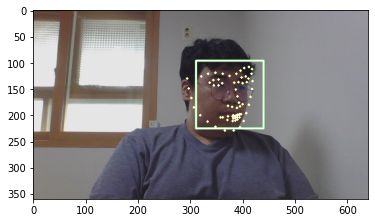

In [33]:
#landmark 표시하기
for landmark2 in list_landmarks2:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show2, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show2, cv2.COLOR_BGR2RGBA)
plt.imshow(img_show_rgb)
plt.show()

음영이 짙고 눈코입의 비율이 달라지자 이전과 다르게 정확하게 못 찾는 형태가 보인다.

In [34]:
#시작점 좌표 확인
x1 = (landmark2[2][0] +  landmark2[36][0] +  landmark2[48][0] +  landmark2[30][0])/4
y1 = (landmark2[2][1] +  landmark2[36][1] +  landmark2[48][1] +  landmark2[30][1])/4
x2 = (landmark2[14][0] +  landmark2[45][0] +  landmark2[54][0] +  landmark2[30][0])/4
y2 = (landmark2[14][1] +  landmark2[45][1] +  landmark2[54][1] +  landmark2[30][1])/4
print("({0}, {1})".format(x1, y1)) #시작점 좌표
print("({0}, {1})".format(x2, y2)) #반대편 대칭되는 점의 좌표

(347.5, 171.25)
(404.75, 163.5)


In [35]:
landmark2[30]

(393, 176)

In [36]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark2[30][0]
    y = landmark2[30][1]
    w = int((landmark2[30][0] - x1) *2) # 스티커의 너비는 이미지 시작점 ~ 얼굴 중심까지의 거리 X 2
#     w = int(x2 - x1)
    h = int(dlib_rect.width() / 4)
#     h = int((y1 - landmark[30][1]) * 2)
    print ('(x,y) : (%d,%d)'%(x,y)) #스티커 위치
    print ('(w,h) : (%d,%d)'%(w,h)) #스티커 크기

(312, 197)
(x,y) : (393,176)
(w,h) : (91,46)


In [37]:
refined_x = int(x1)
refined_y = int(y1)

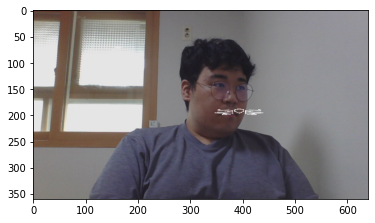

In [38]:
sticker_area = img_bgr2[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x + img_sticker.shape[1]]
img_bgr2[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x + img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr2, cv2.COLOR_BGR2RGBA))
plt.show()

그러나 얼굴로 인식하더라도 이와같이 얼굴의 중심에서 양쪽이 비대칭이 이루어지는 경우 코의 위치(얼굴의 중심)이 조금 빗나가자 덮어씌우는 스티커 역시 상당히 빗나가게된다.

# 데이터 처리
사용할 스티커 데이터의 채널은 4채널(R, G, B, alpha)이다.
np.where()함수의 경우 데이터의 사이즈가 정확히 일치해야하기 때문에 기존 3채널의 이미지 데이터에 알파채널을 만들어 더미데이터를 집어넣어주었다.
또한 눈, 코, 입이 가려지거나 얼굴 윤곽의 일부가 잘린 경우 얼굴로 인식하지 못하는 문제가 발생했다. 옆 모습 역시 양쪽 눈이 모두 보여야 얼굴로 인식했다.

# 좌표 설정
집어넣을 이미지의 크기는 수염 자리에 맞추어 입꼬리, 얼굴 윤곽, 눈꼬리, 코 를 기준으로 중간값을 구하였으며 높이의 경우만 조금 늘려서 삽입하였다.

# 총평
속도에 있어선 모델이 상당히 가벼웠지만 정확도와 성능에 있어선 부족함이 느껴졌다.
가장 큰 문제는 그래디언트 변화를 기준으로 눈, 코, 입을 정하기 때문에 음영이 짙은 경우, 또 눈썹과 눈이 짙거나 옅은 경우에는 정확히 구분하지 못하는 문제가 발생하였다.
이를 위해선 눈과 눈썹같이 얼굴의 일부 중 가장 많은 경우에 나타나면서도 도드라지는 특징에 배점을 높게하여 이를 기준으로 찾는 방식이 있을 수 있을 것 같다 다만 이 경우 얼굴로 보는 범위가 매우 늘어날 것이다.